# Get AA relationship

In [1]:
from katlas.plot import *
from katlas.pssm import *
from matplotlib import pyplot as plt
import pandas as pd,numpy as np, seaborn as sns

In [3]:
# load raw PSPA data
st = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')
tyr = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_tyr_raw.csv').set_index('kinase')

In [4]:
st.shape,tyr.shape # tyr have position 5 while st only have -5 to 4

((303, 207), (93, 230))

In [5]:
st.columns.isin(tyr.columns).sum() # all st columns are in tyr

np.int64(207)

In [6]:
tyr = tyr[st.columns]

In [7]:
df = pd.concat([st,tyr])

In [8]:
# df.to_parquet('pspa_raw_all.parquet')

## Normalize

For each pssm, the value is divided by the sum of position to get probability.

Here we remove pS (or s) column because it is a duplicate of pT.

In [9]:
out=[]
for i,r in df.iterrows():
    pssm = recover_pssm(r).drop(index=['pS']) # drop pS as it is a duplicate of pT
    pssm_norm = pssm/pssm.sum()
    r_norm=flatten_pssm(pssm_norm)
    out.append(r_norm)
    # break

In [10]:
df_norm = pd.DataFrame(out,index=df.index)

In [11]:
df_norm.max().sort_values()

-4V     0.054906
-5Q     0.055054
-3Q     0.060396
-4I     0.061281
4N      0.061402
          ...   
2R      0.647505
-3R     0.659110
4pT     0.744287
2pY     0.756693
-3pT    0.819808
Length: 198, dtype: float64

In [12]:
# Z score normalization: (x-median)/std
# df_norm = df_log.div(df_log.sum(1), axis=0) # normalize per row

# df_norm.max().sort_values()

# df_centered = df_log.sub(df_log.median(axis=1), axis=0) #Median is more robust to outliers than mean

# row_std = df_centered.std(axis=1)

# df_norm = df_centered.div(row_std, axis=0)

## Get aa relationship

Get a pivot table where index are each row in PSSM (flattened) and column as aa

In [13]:
def get_aa_pivot(df):
    df2 = df.unstack().reset_index()
    df2.columns = ['substrate', 'kinase', 'target']
    df2['aa'] = df2.substrate.str.extract(r'-?\d+(.*)')
    df2['enum'] = df2.groupby('aa').cumcount()
    df_pivot = df2.pivot(index='enum', columns='aa', values='target') #(303+93)*207/23=3564 data points per aa
    return df_pivot

In [30]:
get_aa_pivot(df_norm)

aa,A,C,D,E,F,G,H,I,K,L,...,P,Q,R,S,T,V,W,Y,pT,pY
enum,,,,,,,,,,,,,,,,,,,,,
0,0.022689,0.035505,0.012815,0.012230,0.033966,0.019584,0.026494,0.124227,0.020920,0.079374,...,0.057560,0.044781,0.076395,0.037377,0.062864,0.076023,0.025154,0.076070,0.016092,0.048843
1,0.043352,0.051706,0.065975,0.058643,0.044600,0.035740,0.042359,0.046430,0.037911,0.044243,...,0.030841,0.031974,0.035314,0.043700,0.046971,0.044418,0.059664,0.042913,0.058193,0.056499
2,0.041163,0.066089,0.077450,0.065475,0.043931,0.037582,0.037661,0.032179,0.031404,0.034251,...,0.038739,0.036231,0.034316,0.048096,0.049033,0.039515,0.052463,0.044140,0.055400,0.054025
3,0.043296,0.044366,0.029489,0.029495,0.042885,0.046571,0.051207,0.034139,0.074510,0.036415,...,0.047329,0.038554,0.119120,0.058256,0.045790,0.033537,0.041228,0.040494,0.033407,0.033597
4,0.050553,0.054868,0.024011,0.024790,0.043062,0.048498,0.047918,0.032888,0.077033,0.038753,...,0.047364,0.038891,0.116091,0.043582,0.041902,0.034020,0.041962,0.042862,0.035884,0.037412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,0.039978,0.044084,0.032095,0.029349,0.053046,0.048620,0.045832,0.035368,0.073535,0.043720,...,0.062438,0.049294,0.077132,0.047354,0.047700,0.040578,0.052726,0.036062,0.026070,0.025366
3560,0.034813,0.042381,0.042421,0.041581,0.049883,0.046789,0.061897,0.033611,0.054107,0.039796,...,0.054190,0.050606,0.063522,0.042759,0.039404,0.034896,0.060530,0.041920,0.037194,0.041829
3561,0.037825,0.045142,0.028175,0.032509,0.038069,0.042975,0.043249,0.036433,0.093387,0.035088,...,0.035362,0.045697,0.105032,0.045549,0.040374,0.035008,0.057392,0.045191,0.031294,0.038903


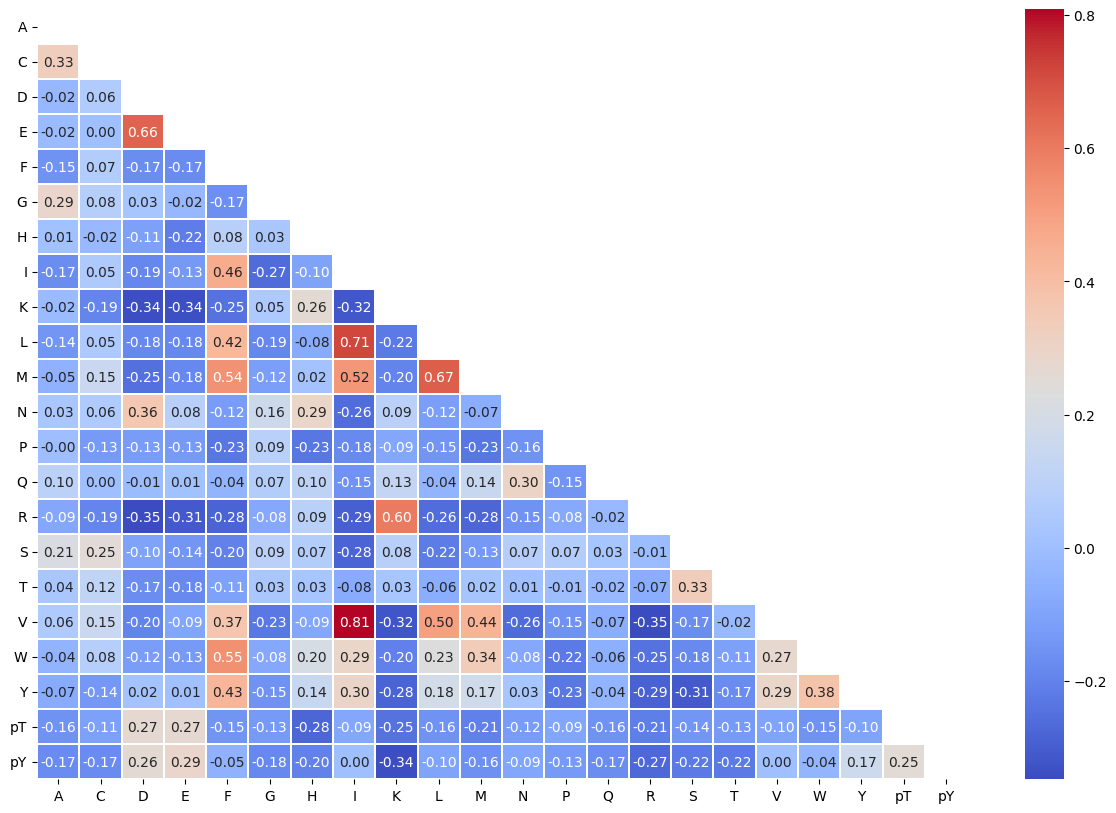

In [16]:
corr = get_aa_pivot(df_norm).corr('pearson')
plot_corr(corr)

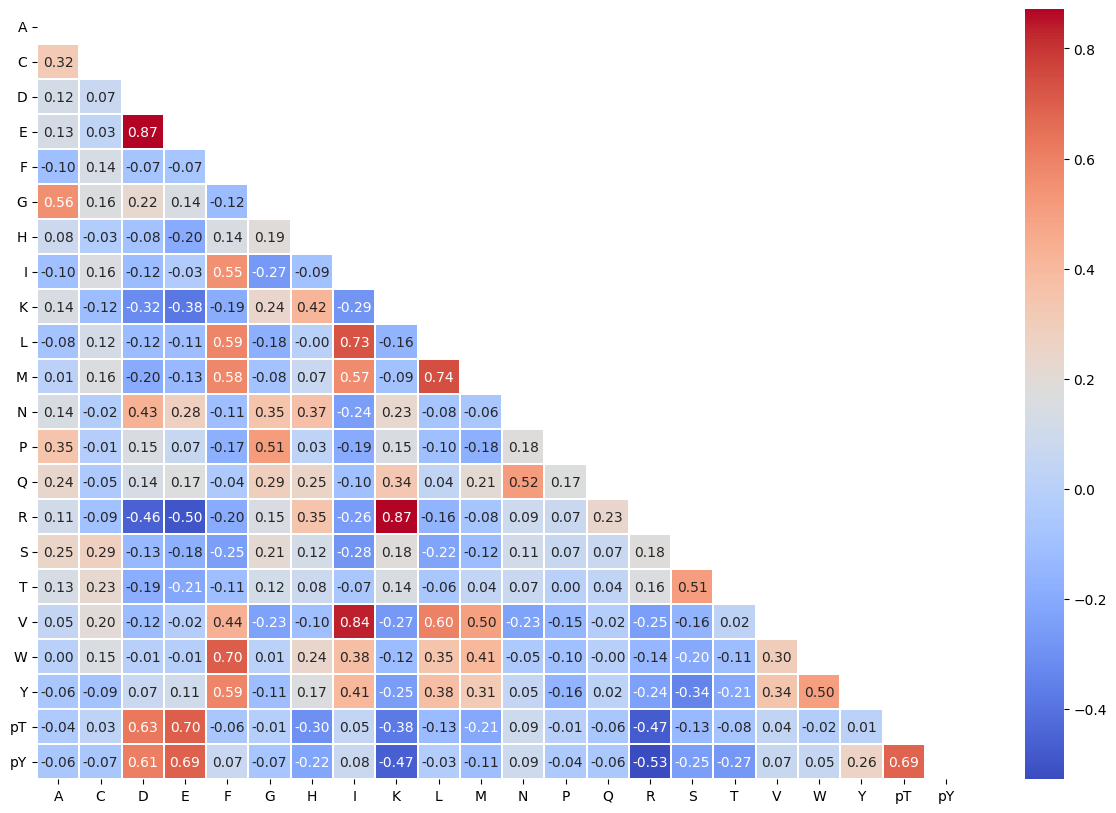

In [23]:
corr = get_aa_pivot(df_norm).corr('spearman')
plot_corr(corr)
save_svg('fig/aa_relationship_spearman.svg')

Although K and R shows high spearman correlation, its PSSM, for example in AKT is not that highly correlated.

In that case, pearson correlation seems to be much related for this set.

In [24]:
def get_corr_pairs(corr):
    out = corr.unstack().sort_values()[lambda x: x<1][::2].sort_values(ascending=False)
    out.index = out.index.map(lambda x: x[0] + '_' + x[1])
    return out

In [26]:
out = get_corr_pairs(corr)
out

R_K     0.871058
D_E     0.870359
V_I     0.837880
L_M     0.741193
I_L     0.726308
          ...   
D_R    -0.460727
K_pY   -0.467009
R_pT   -0.473405
E_R    -0.498652
pY_R   -0.527158
Length: 231, dtype: float64

In [33]:
out[lambda x: x>0.5]

R_K      0.871058
D_E      0.870359
V_I      0.837880
L_M      0.741193
I_L      0.726308
F_W      0.702524
pT_E     0.696542
pY_E     0.692582
pT_pY    0.688888
D_pT     0.625288
D_pY     0.608323
L_V      0.598209
F_Y      0.588376
F_L      0.587369
M_F      0.580984
M_I      0.566043
G_A      0.555320
I_F      0.553406
N_Q      0.515099
G_P      0.511684
S_T      0.506195
Y_W      0.504759
dtype: float64

## Relationship of position+aa

In [34]:
corr_all = df_norm.corr('spearman')

In [35]:
out2 = get_corr_pairs(corr_all)

In [36]:
out2

-5D_-5E    0.950029
-3D_-3E    0.948908
3D_3E      0.931132
2R_2K      0.925424
-2E_-2D    0.913798
             ...   
-5D_-4K   -0.753715
-4R_-3E   -0.756394
-3E_-1K   -0.761640
-3E_-3R   -0.768508
-1R_-3E   -0.768611
Length: 19503, dtype: float64

In [41]:
out2[out2.index.str.contains('pY')].head(15)

-2pY_-3pY    0.846232
-3pY_-4pY    0.837161
-3pT_-3pY    0.830329
-3E_-3pY     0.818490
-3pY_-3D     0.817421
-4pY_-5pY    0.811867
-3pY_-2pT    0.803611
4pY_4E       0.785561
4pT_3pY      0.785136
-5pT_-5pY    0.784180
-4pY_-2pY    0.783532
3pT_3pY      0.782812
4pT_4pY      0.767439
-2pY_-2pT    0.764788
-3pT_-2pY    0.762138
dtype: float64